See CERN-BNL_LinkRegressionFinal for detailed description of motivation and model.

In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch
matplotlib.rc('font', **{'size': 15})


src = 'CERN-PROD'
dst = 'SARA-MATRIX'

In [2]:
query1 = '''{
    
  "size": 10000,
  "sort": [
    {
      "@timestamp": {
        "order": "random",
      }
    }
  ],
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "payload.src-rse:CERN* AND payload.dst-rse:SARA* AND event_type:transfer-done",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "fielddata_fields": [
    "@timestamp","duration"
  ]
}'''

In [3]:
import time

#Initialize convenient time intervals in milliseconds
milliWeek = 7*24*60*60*1000
milliTwoWeek = 2*7*24*60*60*1000
milliThreeWeek = 3*7*24*60*60*1000
milliFourWeek = 4*7*24*60*60*1000
milliSixHour = 12*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHalfDay = 12*60*60*1000
milliHour = 60*60*1000

#currentMilliTime = int(round(time.time()*1000))

#Some time in August 14, 2016, just picked a time to compare across notebooks
currentMilliTime = 1471176912780

In [4]:
import ast

#Get four weeks of data
start = currentMilliTime - milliFourWeek
end = currentMilliTime

hourSeg = 24*7*4
tenMinSeg = 24*7*4*6
milliTenMinutes = 1000*60*10

totalTimestamp = []
totalFileSize = []
totalActivity = []
totalStartedAt = []
totalSubmittedAt = []
totalTransferredAt = []

startPart = start
endPart = start

numNeighborsQueued = []

tic = time.time()

#Step through day, getting all data in range
for i in range(tenMinSeg):
    endPart += milliTenMinutes
    
    #Initialize lists
    fileSize = []
    activity = []
    startedAt = []
    submittedAt = []
    transferredAt = []
    duration = []
    
    #Create instance of ElasticSearch using the Atlas host server
    es1 = Elasticsearch(hosts=[{'host':'atlas-kibana-2.mwt2.org', 'port':9200}],
                        timeout=20,retry_on_timeout = True)
    response = es1.search(index="rucio-events*", body=ast.literal_eval(query1%(startPart,endPart)),
                          request_timeout=20)
    
    #Get important fields
    for r in response['hits']['hits']:
        fileSize.append(r['_source']['payload']['file-size'])
        activity.append(r['_source']['payload']['activity'])
        startedAt.append(r['_source']['payload']['started_at'])
        submittedAt.append(r['_source']['payload']['submitted_at'])
        transferredAt.append(r['_source']['payload']['transferred_at'])
    
    numNeighborsQueued.append([startPart + (endPart - startPart)/2, len(fileSize)])
    
    #Get random indices in range of length of data vectors
    if (len(fileSize) < 100) & (len(fileSize) > 0):
        #Grab all files if there are less than 100
        ind = np.random.choice(len(fileSize),size=len(fileSize),replace=False)
        
        #Append each random sample from the hour's data
        totalFileSize += [ fileSize[i] for i in ind]
        totalActivity += [ activity[i] for i in ind]
        totalStartedAt += [ startedAt[i] for i in ind]
        totalSubmittedAt += [ submittedAt[i] for i in ind]
        totalTransferredAt += [ transferredAt[i] for i in ind]
        
    elif len(fileSize) >= 100:
        #Otherwise just grab 100 randomly
        ind = np.random.choice(len(fileSize),size=100,replace=False)  
        #Append each random sample from the hour's data
        totalFileSize += [ fileSize[i] for i in ind]
        totalActivity += [ activity[i] for i in ind]
        totalStartedAt += [ startedAt[i] for i in ind]
        totalSubmittedAt += [ submittedAt[i] for i in ind]
        totalTransferredAt += [ transferredAt[i] for i in ind]
    
    np.random.seed()
    

    startPart = endPart + 1
    if i%500 == 0:
        print('%f%% of the way there...'%(100*(i/tenMinSeg)))

print("Done. Took %f seconds"%(time.time()-tic))   

0.000000% of the way there...
12.400794% of the way there...
24.801587% of the way there...
37.202381% of the way there...
49.603175% of the way there...
62.003968% of the way there...
74.404762% of the way there...
86.805556% of the way there...
99.206349% of the way there...
Done. Took 745.042607 seconds


Next, we acquire data from the ddm-metrics, 

In [5]:
#Create query template for ddm-metric data
queryTemp = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:%s AND dst:%s",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "10m",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": %i,
          "max": %i
        }
      },
  "aggs": {
    "1": {
          "sum": {
            "field": 'queued-total'
          }
        },
        "2": {
          "sum": {
            "field": 'queued-User_Subscriptions'
          }
        },
        "3": {
          "sum": {
            "field": 'queued-T0_Export'
          }
        },
        "4": {
          "sum": {
            "field": 'queued-Data_Consolidation'
          }
        },
        "5": {
          "sum": {
            "field": 'queued-Functional_Test'
          }
        },
        "6": {
          "sum": {
            "field": 'queued-Express'
          }
        },
        "7": {
          "sum": {
            "field": 'queued-Production_Input'
          }
        },
        "8": {
          "sum": {
            "field": 'queued-Production_Output'
          }
        },
        "9": {
          "sum": {
            "field": 'queued-Staging'
          }
        },
        "10": {
          "avg": {
            "field": 'done-total-1h'
          }
        },
        "11": {
          "avg": {
            "field": 'done-User_Subscriptions-1h'
          }
        },
        "12": {
          "avg": {
            "field": 'done-T0_Export-1h'
          }
        },
        "13": {
          "avg": {
            "field": 'done-Data_Consolidation-1h'
          }
        },
        "14": {
          "avg": {
            "field": 'done-Functional_Test-1h'
          }
        },
        "15": {
          "avg": {
            "field": 'done-Express-1h'
          }
        },
        "16": {
          "avg": {
            "field": 'done-Production_Input-1h'
          }
        },
        "17": {
          "avg": {
            "field": 'done-Production_Output-1h'
          }
        },
        "18": {
          "avg": {
            "field": 'done-Staging-1h'
              }
            },
        
        
        "19": {
          "avg": {
            "field": 'packetloss'
              }
            },
        "20": {
          "avg": {
            "field": 'mbps-dashb-1h'
              }
            },
        "21": {
          "avg": {
            "field": 'mbps-dashb-1d'
              }
            },
        "22": {
          "avg": {
            "field": 'mbps-fts-1h'
              }
            },
        "23": {
          "avg": {
            "field": 'mbps-fts-1d'
              }
            },
        "24": {
          "avg": {
            "field": 'mbps-fax-1h'
              }
            },
        "25": {
          "avg": {
            "field": 'mbps-fax-1d'
              }
            }
      }
    }
  }
}'''

In [6]:
tic = time.time()

#I have to break the data acquisition up into pieces so that Elasticsearch doesn't crash.
startPart = start
endPart = start
numDays = 4*7
response = []
for i in range(numDays):
    
    es2 = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=20,retry_on_timeout=True)
    
    print("Loading data from Day %i..."%(i+1))
    endPart += milliDay  
    query = ast.literal_eval(queryTemp%(src,dst,startPart,endPart,startPart,endPart))
    response.append(es2.search(index="atlas_ddm-metrics*", body=query, request_timeout=20))
    startPart = endPart+1
    
print("Done. Aggregation took %f seconds"%(time.time()-tic))

Loading data from Day 1...
Loading data from Day 2...
Loading data from Day 3...
Loading data from Day 4...
Loading data from Day 5...
Loading data from Day 6...
Loading data from Day 7...
Loading data from Day 8...
Loading data from Day 9...
Loading data from Day 10...
Loading data from Day 11...
Loading data from Day 12...
Loading data from Day 13...
Loading data from Day 14...
Loading data from Day 15...
Loading data from Day 16...
Loading data from Day 17...
Loading data from Day 18...
Loading data from Day 19...
Loading data from Day 20...
Loading data from Day 21...
Loading data from Day 22...
Loading data from Day 23...
Loading data from Day 24...
Loading data from Day 25...
Loading data from Day 26...
Loading data from Day 27...
Loading data from Day 28...
Done. Aggregation took 527.139922 seconds


Next, we need to gather data about network health and activity volumes from ddm-metrics.

In [89]:
timestamp = []

queuedTotal = []
queuedUserSubscriptions = []
queuedT0Export = []
queuedStaging = []
queuedDataConsolidation = []
queuedFunctionalTest = []
queuedExpress = []
queuedProductionInput = []
queuedProductionOutput = []
queuedStaging = []


doneTotal = []
doneUserSubscriptions = []
doneT0Export = []
doneStaging = []
doneDataConsolidation = []
doneFunctionalTest = []
doneExpress = []
doneProductionInput = []
doneProductionOutput = []
doneStaging = []


packetloss = []
dashThroughput1h = []
dashThroughput1d = []
ftsThroughput1h = []
ftsThroughput1d = []
faxThroughput1h = []
faxThroughput1d = []

for i in range(numDays):
    for r in response[i]['aggregations']['2']['buckets']:
        #Get current queued data according to activity
        queuedTotal.append(r['1']['value'])
        queuedUserSubscriptions.append(r['2']['value'])
        queuedT0Export.append(r['3']['value'])
        queuedDataConsolidation.append(r['4']['value'])
        queuedFunctionalTest.append(r['5']['value'])
        queuedExpress.append(r['6']['value'])
        queuedProductionInput.append(r['7']['value'])
        queuedProductionOutput.append(r['8']['value'])
        queuedStaging.append(r['9']['value'])

        #Get historical completion data according to activity
        doneTotal.append(r['10']['value'])
        doneUserSubscriptions.append(r['11']['value'])
        doneT0Export.append(r['12']['value'])
        doneDataConsolidation.append(r['13']['value'])
        doneFunctionalTest.append(r['14']['value'])
        doneExpress.append(r['15']['value'])
        doneProductionInput.append(r['16']['value'])
        doneProductionOutput.append(r['17']['value'])
        doneStaging.append(r['18']['value'])

        #Get other parameters
        packetloss.append(r['19']['value'])
        dashThroughput1h.append(r['20']['value'])
        dashThroughput1d.append(r['21']['value'])
        ftsThroughput1h.append(r['22']['value'])
        ftsThroughput1d.append(r['23']['value'])
        faxThroughput1h.append(r['24']['value'])
        faxThroughput1d.append(r['25']['value'])                              

        timestamp.append(r['key'])

In [90]:
#Some useful functions for date conversion
import datetime
from datetime import datetime

def convertDateToDatetime(dates):
    '''
    Converts string dates to datetime objects
    '''
    datetimeDates = []
    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
        datetimeDates.append(epoch)
    return datetimeDates

def convertDateToMilliEpoch(dates):
    '''
    Converts string dates to milliEpoch values.
    '''
    epochDates = []
    zeroEpoch = datetime.utcfromtimestamp(0)    
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
            
        epochDates.append((epoch - zeroEpoch).total_seconds() * 1000.0)
    return epochDates
        
        
    return datetimeDates

def getSecondsDifference(epochDatesStart,epochDatesFinal):
    diff = []
    for i in range(len(epochDatesStart)):
        diff.append((epochDatesFinal[i] - epochDatesStart[i]).total_seconds())
    
    return diff

#Convenience function that converts lists with None values to arrays with zeroes in their place.
def NoneToNum(noneList):
    numArray = np.nan_to_num(np.array(noneList,dtype=float,copy=True))
    return numArray

In [91]:
#Convert string timestamps to usable quantities for each file

timeInQueue = getSecondsDifference(convertDateToDatetime(totalSubmittedAt),
                                   convertDateToDatetime(totalStartedAt))
timeTotal = getSecondsDifference(convertDateToDatetime(totalSubmittedAt),
                                 convertDateToDatetime(totalTransferredAt))
timeInTransfer = getSecondsDifference(convertDateToDatetime(totalStartedAt),
                                      convertDateToDatetime(totalTransferredAt))

#May regress separately on these variables eventually to get prediction of both queue-time and transfer-time
timeInQueue = np.array(timeInQueue)
timeInTransfer = np.array(timeInTransfer)

#For now, just predict total time from this variable
timeTotal = np.array(timeTotal)


In [92]:
#Get times that each file is submitted at
submittedTimes = np.array(convertDateToMilliEpoch(totalSubmittedAt))

#Get indices for sorting all ddm-metrics variables in ascending order based on submission time
timeIndex = np.argsort(submittedTimes)

submittedTimesSorted = submittedTimes[timeIndex].copy()

#Sort ddm-metrics data
activity = np.array(totalActivity)[timeIndex]
filesize = np.array(totalFileSize)[timeIndex]
timeTotalSorted = timeTotal[timeIndex].copy()
timeInQueueSorted = timeInQueue[timeIndex].copy()
timeInTransferSorted = timeInTransfer[timeIndex].copy()

In order to regress based on activity, a categorical variable, the categories are converted to n-vectors, where n is the number of categories for the variable. For each observation, the index corresponding to the appropriate category holds a value of 1, and the rest of the indices are zero.

In [93]:
#Convert categories to n-vectors

uniqueActivities = np.unique(activity)
vec = np.zeros(len(uniqueActivities))

dummyActivity = []

for i in range(len(activity)):
    vecNew = vec.copy()
    vecNew[np.where(uniqueActivities == activity[i])] = 1
    dummyActivity.append(vecNew)
dummyActivity = np.array(dummyActivity)

In [94]:
#Additional metric in development, ignore for now
#temp = np.array(numNeighborsQueued,dtype=float,copy=True)
#neighborTime = temp[:,0]
#numNeighbors = temp[:,1]
#binIndex2 = np.digitize(submittedTimesSorted,neighborTime)-1

#numNeighbors2 = numNeighbors[binIndex2].copy()

In [95]:
timestamp = np.array(timestamp, dtype=float)

#Get indices that relate the two timescales between metrics, so that the correct network performance values may be
#associated with each file
binIndex = np.digitize(submittedTimesSorted,timestamp)-1

#Convert lists to arrays, and None objects to NaNs, for queued and done data. In these cases, NaNs represent the absence
#of files in the category, rather than actual missing data.
queuedTotal = NoneToNum(queuedTotal)[binIndex]
queuedUserSubscriptions = NoneToNum(queuedUserSubscriptions)[binIndex]
queuedT0Export = NoneToNum(queuedT0Export)[binIndex]
queuedStaging = NoneToNum(queuedStaging)[binIndex]
queuedDataConsolidation = NoneToNum(queuedDataConsolidation)[binIndex]
queuedFunctionalTest = NoneToNum(queuedFunctionalTest)[binIndex]
queuedExpress = NoneToNum(queuedExpress)[binIndex]
queuedProductionInput = NoneToNum(queuedProductionInput)[binIndex]
queuedProductionOutput = NoneToNum(queuedProductionOutput)[binIndex]
queuedStaging = NoneToNum(queuedStaging)[binIndex]

doneTotal = NoneToNum(doneTotal)[binIndex]
doneUserSubscriptions = NoneToNum(doneUserSubscriptions)[binIndex]
doneT0Export = NoneToNum(doneT0Export)[binIndex]
doneStaging = NoneToNum(doneStaging)[binIndex]
doneDataConsolidation = NoneToNum(doneDataConsolidation)[binIndex]
doneFunctionalTest = NoneToNum(doneFunctionalTest)[binIndex]
doneExpress = NoneToNum(doneExpress)[binIndex]
doneProductionInput = NoneToNum(doneProductionInput)[binIndex]
doneProductionOutput = NoneToNum(doneProductionOutput)[binIndex]
doneStaging = NoneToNum(doneStaging)[binIndex]

#Likewise, the packet loss parameter is only taken when it rises above a certain value, so empty values can safely be
#set to zero.
loss = NoneToNum(packetloss)[binIndex]


dashThroughput1h = np.array(dashThroughput1h,dtype=float)[binIndex]
dashThroughput1d = np.array(dashThroughput1d,dtype=float)[binIndex]
ftsThroughput1h = np.array(ftsThroughput1h,dtype=float)[binIndex]
ftsThroughput1d = np.array(ftsThroughput1d,dtype=float)[binIndex]
faxThroughput1h = np.array(faxThroughput1h,dtype=float)[binIndex]
faxThroughput1d = np.array(faxThroughput1d,dtype=float)[binIndex]

In [96]:
def convertSecsToCat(data):
    timeCategory = np.zeros(len(data),dtype=int)
    for i in range(len(data)):
        if data[i] < 600: #Less than 10 min
            timeCategory[i] = 0
        elif data[i] >= 600 and data[i] < 1200:#(10-20 min)
            timeCategory[i] = 1
        elif (data[i] >= 1200 and data[i] < 3600): #(between 20 min and 1 hour)
            timeCategory[i] = 2
        elif data[i] >=3600 and data[i] < 7200: #(between 1 and 2 hr)
            timeCategory[i] = 3
        elif data[i] >= 7200 and data[i] < 18000: #(2-5 hour)
            timeCategory[i] = 4
        elif data[i] >= 18000: #Greater than or equal to 5 hours
            timeCategory[i] = 5
    return timeCategory

In [97]:
from sklearn.ensemble import (GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,
                              ExtraTreesRegressor)

#Form input by combining various variables.
inputSample = np.squeeze(np.hstack((submittedTimesSorted[:,None],queuedUserSubscriptions[:,None],
                                    queuedT0Export[:,None],queuedStaging[:,None],
                                    queuedDataConsolidation[:,None],queuedFunctionalTest[:,None],
                                    queuedExpress[:,None],queuedProductionInput[:,None],
                                    queuedProductionOutput[:,None],queuedStaging[:,None],queuedTotal[:,None],
                                    #doneUserSubscriptions[:,None],
                                    #doneT0Export[:,None],doneStaging[:,None],
                                    #doneDataConsolidation[:,None],doneFunctionalTest[:,None],
                                    #doneExpress[:,None],doneProductionInput[:,None],
                                    #doneProductionOutput[:,None],doneStaging[:,None],
                                    dashThroughput1h[:,None],ftsThroughput1h[:,None],dashThroughput1d[:,None],
                                    ftsThroughput1d[:,None],filesize[:,None],dummyActivity)))
outputSample = timeTotalSorted.copy()

#Find rows of data that contain at least one missing value
missing = np.isnan(np.sum(inputSample,axis=1))

reducedInput = inputSample[~missing].copy()
reducedOutput = outputSample[~missing].copy()
activity = activity[~missing].copy()


#First 80% of data to train on, and test on the last 20%
sp = int(round(0.80*len(reducedOutput)))

X_train = reducedInput[:sp,:].copy()
Y_train = reducedOutput[:sp].copy()
X_test = reducedInput[sp:].copy()
Y_test = reducedOutput[sp:].copy()

model = RandomForestRegressor(n_estimators=10)
Y_predict = model.fit(X_train[:,1:],Y_train).predict(X_test[:,1:])


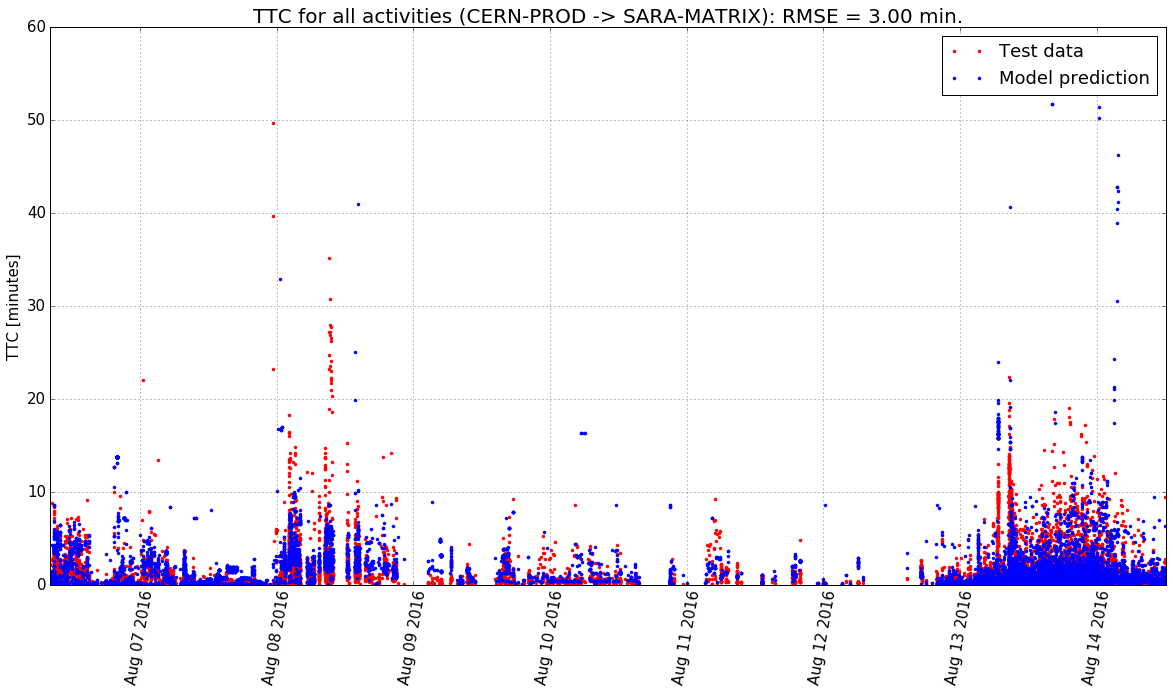

In [98]:
import matplotlib.dates as dt

dateTime = dt.epoch2num(X_test[:,0]/1000.)


plt.figure(figsize=(20,10))

plt.plot_date(dateTime,Y_test/60.,'r.',label='Test data')
plt.plot_date(dateTime,Y_predict/60.,'b.',label='Model prediction')
plt.ylabel("TTC [minutes]")

ax = plt.gca()
#Tedious date/time formatting

plt.xticks(rotation= 80 )
plt.grid()
plt.legend()
plt.title("TTC for all activities (CERN-PROD -> SARA-MATRIX): RMSE = %.2f min."
          %np.sqrt(np.mean((Y_test/60.-Y_predict/60.)**2)),size=20)

/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


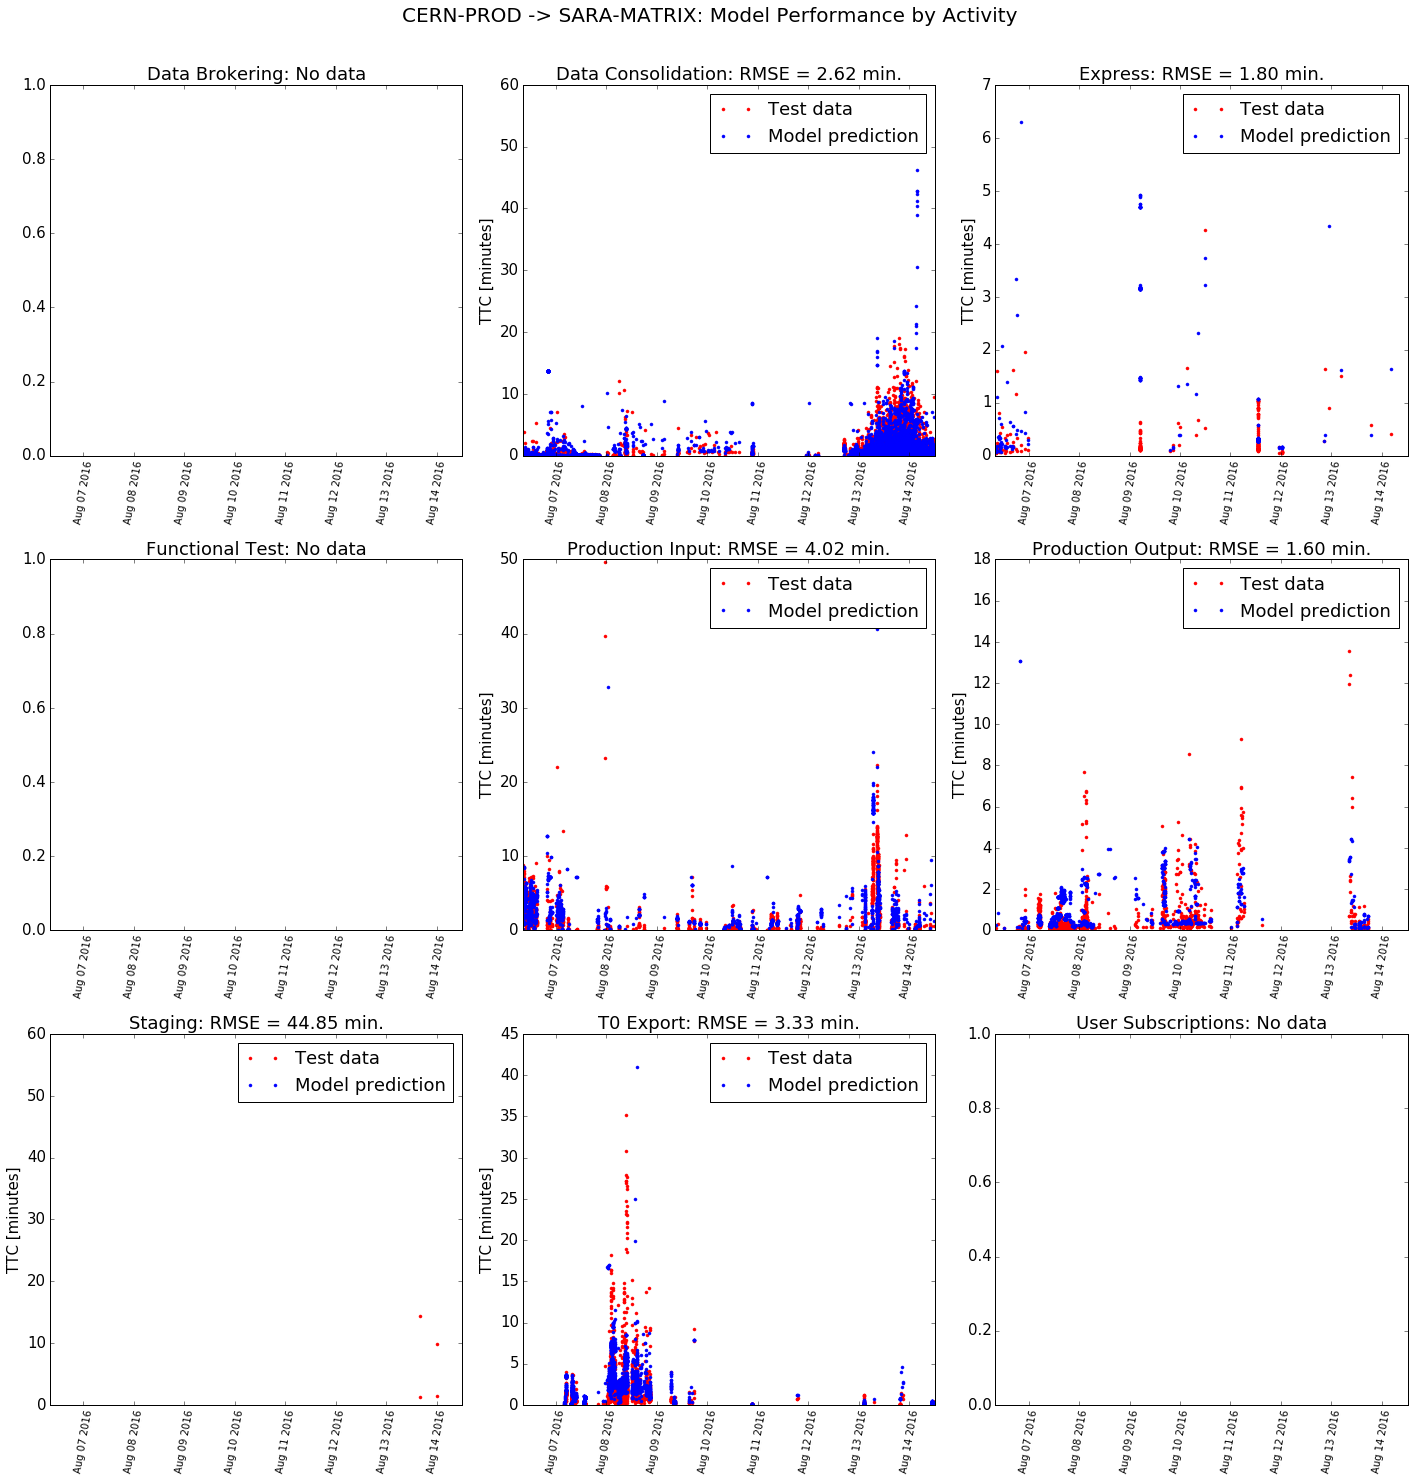

In [99]:
import matplotlib.dates as dt

plt.figure(figsize=(20,20))

uniqueActivities = np.unique(totalActivity)
for u in range(len(uniqueActivities)):
    plt.subplot(3,3,u+1,sharex=ax)
    currentIndex = np.array(activity[sp:])==uniqueActivities[u]
    
    dateTime = dt.epoch2num(X_test[currentIndex,0]/1000.)
    
    rms = np.sqrt(np.mean((Y_test[currentIndex]/60.-Y_predict[currentIndex]/60.)**2))

    if str(rms) == "nan":
        plt.title('%s: No data'%(uniqueActivities[u]))
        plt.xticks(rotation=80,size=10)
    else:
        
        plt.plot_date(dateTime,Y_test[currentIndex]/(60.),'r.',label='Test data')
        plt.plot_date(dateTime,Y_predict[currentIndex]/(60.),'b.',label='Model prediction')
        plt.ylabel('TTC [minutes]')
        plt.xticks(rotation=80,size=10)
        plt.title("%s: RMSE = %.2f min."%(uniqueActivities[u],rms))
        plt.legend()
        
plt.tight_layout()
plt.suptitle('CERN-PROD -> SARA-MATRIX: Model Performance by Activity',size=20,y=1.03)
plt.show()